In [1]:
import medleydb as mdb
import mir_eval

import os
import numpy as np
import scipy
import csv
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
F_THRESH = 0.8/12.0
MIN_CONTOUR_LEN = 0.02

HOP = 256.0  # Tony default hop size
FS = 44100.0  # Tony default output sample rate

SR = FS/HOP
# HOP = (1.0/SR) + 0.0001 

In [3]:
256.0/44100.0

0.005804988662131519

In [4]:
def get_time_stamps(total_duration):
    """Get a list of evenly spaced time stamps based on Tony's parameters.

    Parameters
    ----------
    total_duration : float
        Length (in seconds) of annotation's corresponding audio file.

    Returns
    -------
    time_stamps : array
        Array of evenly spaced time stamps spanning the entire annotation.
    """
    n_stamps = int(np.ceil((total_duration*FS)/HOP))
    return np.arange(n_stamps)*(HOP/FS)


def make_blank_f0_sequence(total_duration):
    """Make a complete f0 sequence filled with 0's.
    First column is time, second column is frequency.

    Parameters
    ----------
    total_duration : float
        Length (in seconds) of annotation's corresponding audio file.

    Returns
    -------
    f0_sequence : array
        Array of filled in f0 values and corresponding time stamps.
    """
    time_stamps = get_time_stamps(total_duration)
    f0_sequence = np.zeros((len(time_stamps), 2))
    f0_sequence[:, 0] = time_stamps
    return f0_sequence


def sec_to_idx(time_in_seconds, sample_rate=FS, hop=HOP):
    """Compute the array index of a given time stamp.

    Parameters
    ----------
    time_in_seconds : float
        Time stamp, in seconds.
    sample_rate : float
        Annotation sample rate.
    hop : float
        Annotation hop size.

    Returns
    -------
    array_idx : int
        Index of time stamp in filled f0 array.
    """
    return int(np.round(time_in_seconds*sample_rate/hop))

In [5]:
def get_confidence_interpolator(mtrack, stem_idx):
    conf = np.array(mtrack.activation_conf_from_stem(stem_idx)).T
    conf_interp = scipy.interpolate.interp1d(
        conf[0], conf[1], fill_value=0, assume_sorted=True,
        bounds_error=False
    )
    return conf_interp

In [6]:
def fill_annotation(pitch_annotation, duration,
                    confidence_interpolator, activation_filter,
                    conf_thresh=0.5):
    if duration is None:
        duration = np.max(np.array(pitch_annotation).T[0])

    start_idx = sec_to_idx(0)
    end_idx = sec_to_idx(duration)
    f0_sequence = make_blank_f0_sequence(duration)
    for time_freq in pitch_annotation:
        time = time_freq[0]
        if activation_filter:
            conf = confidence_interpolator(time)
            freq = time_freq[1] if conf >= conf_thresh else 0.0
        else:
            freq = time_freq[1]

        time_idx = sec_to_idx(time)
        if time_idx >= start_idx and time_idx < end_idx:
            f0_sequence[time_idx][1] = freq
    f0_sequence = np.array(f0_sequence)
    f0_sequence = f0_sequence.T
    times = f0_sequence[0]
    freqs = f0_sequence[1]
    return times, freqs

In [7]:
def score_pyin_est(mtrack, activation_filter=True, make_plot=False, conf_thresh=0.5):
    all_scores = []
    for stem in mtrack.stems.values():
        if not (os.path.exists(stem.pitch_path) and os.path.exists(stem.pitch_pyin_path)):
            continue
        else:
            conf_interp = get_confidence_interpolator(mtrack, stem.stem_idx)

            ref_times, ref_freqs = fill_annotation(
                stem.pitch_annotation, mtrack.duration,
                conf_interp, activation_filter, conf_thresh=conf_thresh
            )
            est_times, est_freqs = fill_annotation(
                stem.pitch_estimate_pyin, mtrack.duration,
                conf_interp, activation_filter, conf_thresh=conf_thresh
            )

            if make_plot:
                plt.title(stem.instrument)
                plt.plot(ref_times, ref_freqs, '.b')
                plt.plot(est_times, est_freqs, ',r')
                plt.show()

            scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
            all_scores.append(scores)

    return all_scores

In [8]:
mtracks = mdb.load_all_multitracks("V1")

all_scores_activation_filter = []
all_scores_no_filter = []
for mtrack in mtracks:
    if mtrack.has_bleed:
        continue

    print(mtrack.track_id)
    scores_filter = score_pyin_est(mtrack, activation_filter=True)
    scores_no_filter = score_pyin_est(mtrack, activation_filter=False)

    all_scores_activation_filter.extend(scores_filter)
    all_scores_no_filter.extend(scores_no_filter)

AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_BluesForNofi
EthanHein_GirlOnABridge
EthanHein_HarmonicaFigure
FacesOnFilm_WaitingForGa
Grants_PunchDrunk
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNelson_Coldwar
LizNelson_Rainfall
Lushlife_ToynbeeSuite
MatthewEntwistle_AnEveningWithOliver
MatthewEntwistle_DontYouEver
MatthewEntwistle_FairerHopes
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_TheArch
MatthewEntwistle_TheFlaxenField
Meaxic_TakeAStep
Meaxic_You

In [10]:
df_filter = pd.DataFrame(all_scores_activation_filter)
df_nofilter = pd.DataFrame(all_scores_no_filter)

In [11]:
df_filter.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.793635,0.826731,0.802154,0.253236,0.883221
std,0.129777,0.215207,0.242478,0.158049,0.222430
min,0.269296,0.054825,0.000000,0.004871,0.100719
25%,0.742521,0.812641,0.782888,0.144760,0.916579
50%,0.823278,0.901578,0.889598,0.226096,0.977078
75%,0.882378,0.958795,0.955565,0.328118,0.989691
max,0.987860,0.992760,0.992308,0.782133,1.000000


In [12]:
df_nofilter.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.718622,0.827138,0.802726,0.409816,0.884036
std,0.144496,0.214265,0.241029,0.208167,0.220506
min,0.239610,0.054427,0.000000,0.021235,0.103844
25%,0.633791,0.812712,0.783194,0.266211,0.916741
50%,0.757816,0.901580,0.890338,0.414625,0.977093
75%,0.806203,0.959467,0.956129,0.558064,0.989691
max,0.975918,0.992760,0.992308,0.880809,1.000000


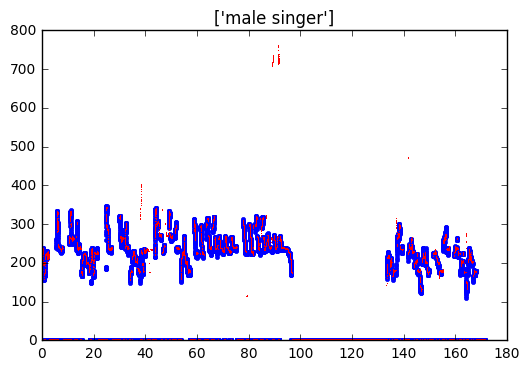

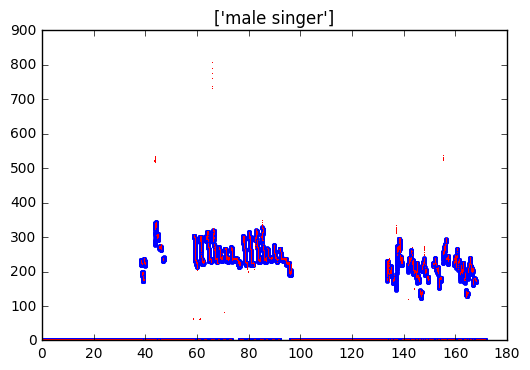

[OrderedDict([('Voicing Recall', 0.97984728017003853),
              ('Voicing False Alarm', 0.2144851761630325),
              ('Raw Pitch Accuracy', 0.908053215775801),
              ('Raw Chroma Accuracy', 0.91230418011493353),
              ('Overall Accuracy', 0.83822035619963431)]),
 OrderedDict([('Voicing Recall', 0.98494780286477301),
              ('Voicing False Alarm', 0.057616453794139745),
              ('Raw Pitch Accuracy', 0.96309783928137893),
              ('Raw Chroma Accuracy', 0.96358339402767657),
              ('Overall Accuracy', 0.94816144105099209)])]

In [14]:
mtrack = mdb.MultiTrack('AClassicEducation_NightOwl')
score_pyin_est(mtrack, activation_filter=True, make_plot=True, conf_thresh=0.5)

In [20]:
import seaborn as sns
sns.set()

In [24]:
mtrack = mdb.MultiTrack('Adele_SomeoneLikeYou')
for s in mtrack.stems.values():
    print s.instrument
    print s.stem_idx

['piano']
1
['female singer']
2


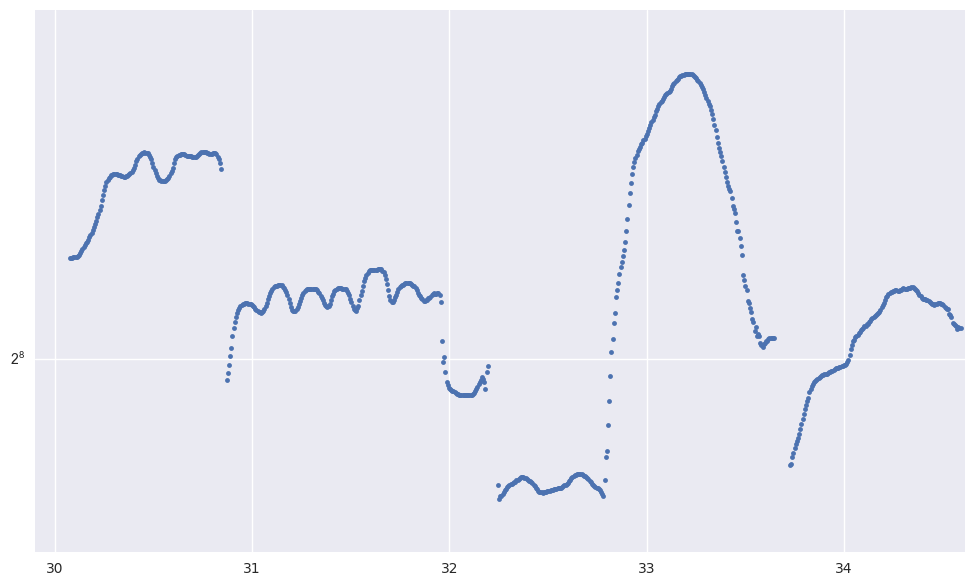

In [58]:
st = mtrack.stems[2]
data = np.array(st.pitch_estimate_pyin)
data = data.T
t = data[0]
f = data[1]

plt.figure(figsize=(12, 7))
plt.semilogy(t, f, '.', basey=2)
plt.xlim(29.9, 34.615)
plt.ylim(200, 400)
plt.savefig('/Users/rabitt/Desktop/contours.png', format='png')